I will construct three model and use three targets:
* Age
* Gender
* Ethnicity

After training models I'm going to create a function which will predict these three parameters by photo.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

So, there are three targets:

Age: range from 1 to 116 <br>
Ethnicity: 0 - White, 1 - Black, 2 - Asian, 3 - Indian, 4 - Other  <br>
Gender: 0 - male, 1 - female <br>

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('drive/MyDrive/datasets/age_gender.csv')

Mounted at /content/drive


In [4]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


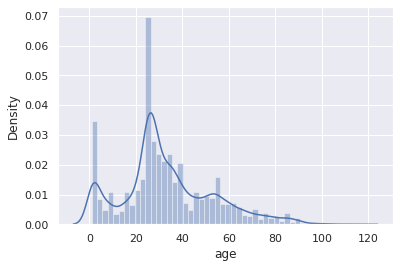

In [6]:
# Age
sns.distplot(df['age']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


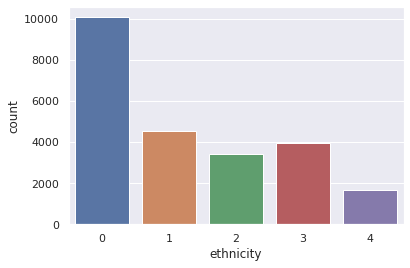

In [7]:
# Ethnicity
sns.countplot(df['ethnicity']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


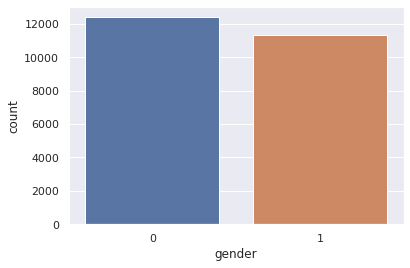

In [8]:
# Gender
sns.countplot(df['gender']);

Actually imaeges in dataset are in string format, let's transform it in more useful type of data.

In [9]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

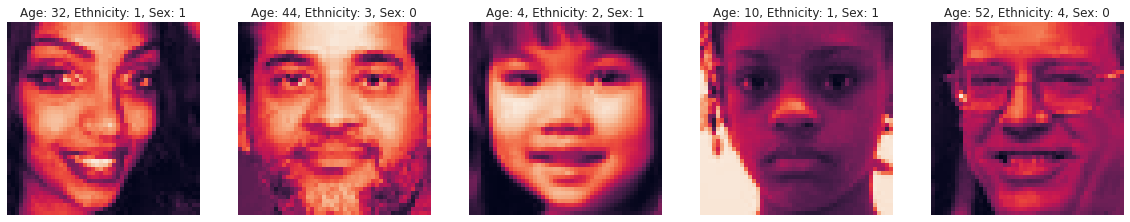

In [10]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face])
    axes[i].axis('off')


## CNN

In [11]:
# Reshape images for CNN
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)

In [12]:
# Normalise images
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255

In [13]:
# Set some useful variables
input_shape = X_reshaped.shape[1:] 

n_epochs = 25
batch_size = 64

## Age prediction

So let's start with age prediction. 

In [14]:
# Set y
y = df['age'].values

In [15]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [16]:
age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.5))
age_model.add(BatchNormalization())

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1))

age_model.compile(optimizer='adam', loss='mse')

age_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 128)       0

In [17]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [18]:
history = age_model.fit(X_train, y_train, 
                        epochs=n_epochs,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/25
297/297 [==============================] - 49s 51ms/step - loss: 234.5353 - val_loss: 1506.1169
Epoch 2/25
297/297 [==============================] - 14s 49ms/step - loss: 140.3038 - val_loss: 293.9843
Epoch 3/25
297/297 [==============================] - 14s 49ms/step - loss: 124.4231 - val_loss: 349.4890
Epoch 4/25
297/297 [==============================] - 14s 48ms/step - loss: 115.4790 - val_loss: 223.4172
Epoch 5/25
297/297 [==============================] - 15s 49ms/step - loss: 102.2275 - val_loss: 186.8291
Epoch 6/25
297/297 [==============================] - 15s 49ms/step - loss: 97.5056 - val_loss: 122.2436
Epoch 7/25
297/297 [==============================] - 14s 49ms/step - loss: 92.2255 - val_loss: 98.8168
Epoch 8/25
297/297 [==============================] - 14s 49ms/step - loss: 87.5555 - val_loss: 140.5943
Epoch 9/25
297/297 [==============================] - 14s 49ms/step - loss: 81.0634 - val_loss: 97.5940
Epoch 10/25
297/297 [==============================

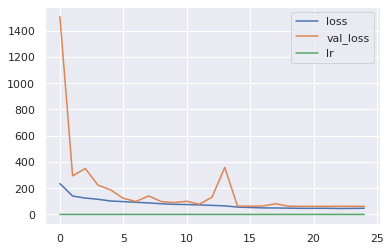

In [19]:
pd.DataFrame(history.history).plot();

In [20]:
valid_score = age_model.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 2s 10ms/step - loss: 61.1776


In [21]:
# Make predictions 
y_pred = age_model.predict(X_test)

In [22]:
# Man absolute error
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.470946032207391


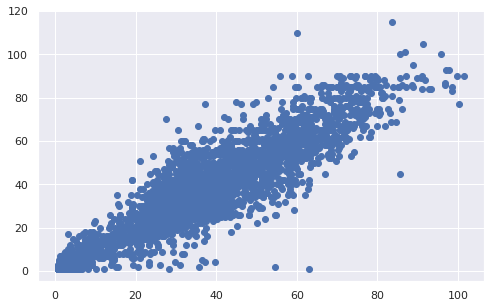

In [23]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, y_test);

So, mean absolute error around 5.5 years it's not so super result considering mean age is 33, it's about 17%.

## Gender prediction

In [24]:
# Set y
y = df['gender'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [25]:
gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
#gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

gender_model.add(Flatten())

gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

gender_model.add(Dense(1, activation='sigmoid')) #For binary classification activation function is sigmoid 

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #...and loss function is binary_crossentropy

gender_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 10, 128)      

In [26]:
# Callbacks for gender model
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1)]

In [27]:
history = gender_model.fit(X_train, y_train, 
                           epochs=n_epochs,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

Epoch 1/25
297/297 [==============================] - 11s 31ms/step - loss: 0.5069 - accuracy: 0.7565 - val_loss: 0.9482 - val_accuracy: 0.5206
Epoch 2/25
297/297 [==============================] - 9s 30ms/step - loss: 0.3542 - accuracy: 0.8390 - val_loss: 0.4265 - val_accuracy: 0.8300
Epoch 3/25
297/297 [==============================] - 9s 30ms/step - loss: 0.3166 - accuracy: 0.8568 - val_loss: 0.3069 - val_accuracy: 0.8644
Epoch 4/25
297/297 [==============================] - 9s 30ms/step - loss: 0.2915 - accuracy: 0.8721 - val_loss: 0.2653 - val_accuracy: 0.8831
Epoch 5/25
297/297 [==============================] - 9s 30ms/step - loss: 0.2739 - accuracy: 0.8798 - val_loss: 0.2621 - val_accuracy: 0.8901
Epoch 6/25
297/297 [==============================] - 9s 30ms/step - loss: 0.2666 - accuracy: 0.8837 - val_loss: 0.2591 - val_accuracy: 0.8838
Epoch 7/25
297/297 [==============================] - 9s 30ms/step - loss: 0.2485 - accuracy: 0.8920 - val_loss: 0.3588 - val_accuracy: 0.823

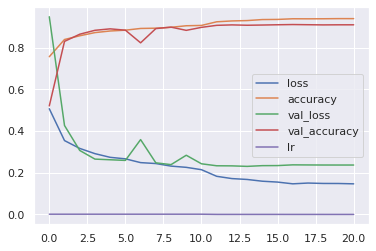

In [28]:
pd.DataFrame(history.history).plot()

In [29]:
# Metrics
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

149/149 [==============================] - 1s 7ms/step - loss: 0.2369 - accuracy: 0.9095
Accuracy for test set: 0.9095127582550049


In [30]:
y_pred=gender_model.predict(X_test) 
y_pred=np.argmax(y_pred,axis=1)


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      2468
           1       0.00      0.00      0.00      2273

    accuracy                           0.52      4741
   macro avg       0.26      0.50      0.34      4741
weighted avg       0.27      0.52      0.36      4741



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


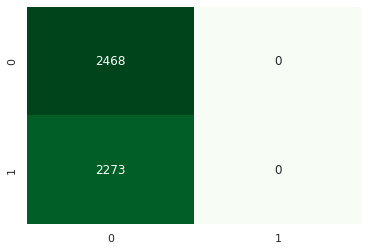

In [32]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');

I suppose big part of this mistakes is children. Let's see some examples where's model had made mistake.

In [33]:
y_pred = y_pred.reshape(y_pred.shape[0])

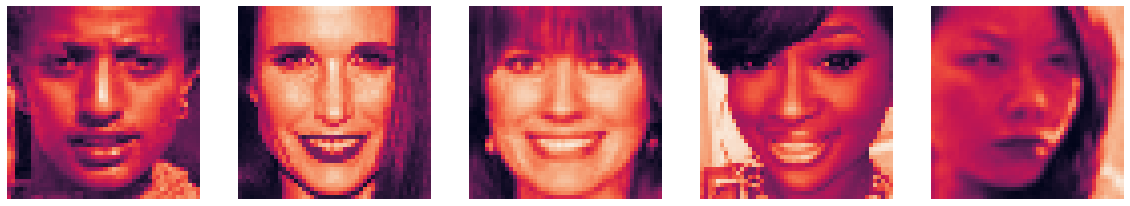

In [34]:
# Model predict is male, but actually it's female

X_fn = X_test[(y_pred == 0) & (y_test == 1)]  

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    
    random_choice = np.random.choice(len(X_fn))
    axes[i].imshow(X_fn[random_choice].reshape(48, 48))
    axes[i].axis('off')

So, on many photos difference between genders are not so clear.

## Ethnicity prediction

In [35]:
# Set y
y = df['ethnicity'].values

# Multiclass problem transform to one_hot_encoding
y = to_categorical(y, 5)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [36]:
eth_model = Sequential()

eth_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(BatchNormalization())

eth_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
eth_model.add(MaxPooling2D(pool_size=(2,2)))
eth_model.add(Dropout(0.5))
eth_model.add(BatchNormalization())

eth_model.add(Flatten())
eth_model.add(Dense(128, activation='relu'))
eth_model.add(Dropout(0.5))
eth_model.add(Dense(5, activation='softmax')) #For multiclass classification activation function is softmax 

eth_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #...and loss function is categorical_crossentropy

eth_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 256)        

In [37]:
# Callbacks for ethnicity model
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
             ReduceLROnPlateau(patience=2, verbose=1)]

In [38]:
history = eth_model.fit(X_train, y_train, 
                         epochs=n_epochs,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         validation_data=(X_test, y_test))

Epoch 1/25
297/297 [==============================] - 9s 26ms/step - loss: 1.1944 - accuracy: 0.5622 - val_loss: 3.0576 - val_accuracy: 0.4318
Epoch 2/25
297/297 [==============================] - 7s 25ms/step - loss: 0.9088 - accuracy: 0.6809 - val_loss: 1.3684 - val_accuracy: 0.5478
Epoch 3/25
297/297 [==============================] - 7s 25ms/step - loss: 0.8269 - accuracy: 0.7120 - val_loss: 0.8095 - val_accuracy: 0.6973
Epoch 4/25
297/297 [==============================] - 7s 25ms/step - loss: 0.7649 - accuracy: 0.7358 - val_loss: 0.7744 - val_accuracy: 0.7174
Epoch 5/25
297/297 [==============================] - 7s 25ms/step - loss: 0.7105 - accuracy: 0.7542 - val_loss: 0.7925 - val_accuracy: 0.7304
Epoch 6/25
297/297 [==============================] - 7s 25ms/step - loss: 0.6702 - accuracy: 0.7695 - val_loss: 0.7309 - val_accuracy: 0.7460
Epoch 7/25
297/297 [==============================] - 8s 25ms/step - loss: 0.6347 - accuracy: 0.7811 - val_loss: 0.6900 - val_accuracy: 0.7469

In [39]:
valid_score = eth_model.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 1s 8ms/step - loss: 0.5961 - accuracy: 0.8127


In [40]:
y_pred=eth_model.predict(X_test) 
y_pred=np.argmax(y_pred,axis=1)


In [41]:
# Convert to 0 to 4 scale 
y_test_labels = [np.argmax(i) for i in y_test]

In [42]:
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2047
           1       0.86      0.84      0.85       904
           2       0.85      0.87      0.86       657
           3       0.74      0.79      0.76       804
           4       0.39      0.22      0.28       329

    accuracy                           0.81      4741
   macro avg       0.74      0.72      0.72      4741
weighted avg       0.80      0.81      0.80      4741



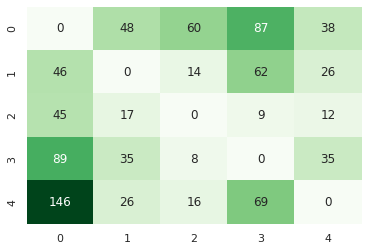

In [43]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

np.fill_diagonal(cm, 0) #Fill diagonal with 0 for better visualisation
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greens');

In [44]:
def face_prediction(image):
    
    x = image.reshape(1, 48, 48, 1)
    x = x / 255

    
    a2=gender_model.predict(x) 
    a2=np.argmax(a2,axis=1)

    
    a3=eth_model.predict(x) 
    a3=np.argmax(a3,axis=1)

    
    age_predict = int(age_model.predict(x))
    gender_predict = int(a2)
    ethnicity_predict = int(a3)

    a2=gender_model.predict(x) 
    a2=np.argmax(a2,axis=1)



    
    gender = {0: 'Male', 1: 'Female'}
    eth_group = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'} 
    
    plt.imshow(image)
    plt.title('{0}, {1}, {2}'.format(age_predict, gender[gender_predict], eth_group[ethnicity_predict]))
    plt.axis('off')

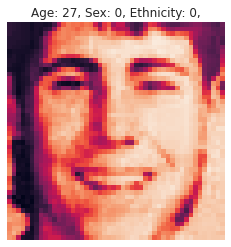

In [45]:
# Final check
random_face = np.random.choice(len(df))

age = df['age'][random_face]
ethnicity = df['ethnicity'][random_face]
gender = df['gender'][random_face]

plt.imshow(df['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}, Ethnicity: {2},'.format(age, gender, ethnicity))
plt.axis('off');

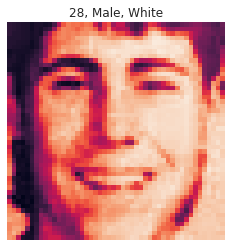

In [46]:
# Model prediction 
face_prediction(df['pixels'][random_face])